# Obtencion de la data

Se eligieron 8 frutas, de las cuales se agarraron 20000 dibujos de cada uno para entrenar la red

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
from skimage.draw import line_aa
from scipy.sparse import csr_matrix

Funcion del repo para convertir los binarios a un dataframe

In [3]:
import struct
from struct import unpack


def unpack_drawing(file_handle):
    key_id, = unpack('Q', file_handle.read(8))
    country_code, = unpack('2s', file_handle.read(2))
    recognized, = unpack('b', file_handle.read(1))
    timestamp, = unpack('I', file_handle.read(4))
    n_strokes, = unpack('H', file_handle.read(2))
    image = []
    for i in range(n_strokes):
        n_points, = unpack('H', file_handle.read(2))
        fmt = str(n_points) + 'B'
        x = unpack(fmt, file_handle.read(n_points))
        y = unpack(fmt, file_handle.read(n_points))
        image.append((x, y))

    return {
        'recognized': recognized,
        'image': image
    }

def unpack_drawings(filename):
    with open(filename, 'rb') as f:
        while True:
            try:
                yield unpack_drawing(f)
            except struct.error:
                break




"Hiperparametros" generales del modelo, se puede agrandar el sample hasta 1769461 dibujos, segun la cantidad de procesamiento que tengas, yo llego hasta 100000. A su vez elegi estos 12 alimentos pero podes quitarlos a gusto

In [4]:
subSample = 20000
foods = ["apple","asparagus","banana","broccoli","onion","pineapple","strawberry","watermelon"]

In [5]:
data = pd.DataFrame(columns=["image", "preds"])

Aca los agrupo a todos en un dataframe, y me quedo solamente con los dibujos que la IA de google reconocio

In [7]:
for food in tqdm(foods):
    print(food)
    df = pd.DataFrame(unpack_drawings(f'../data/full_binary_{food}.bin'))
    df = df[df["recognized"] == 1][["image"]]
    df.loc[:, 'preds'] = food
    data = pd.concat([df.sample(subSample), data], ignore_index=True)

  0%|          | 0/8 [00:00<?, ?it/s]

apple


 12%|█▎        | 1/8 [00:02<00:16,  2.36s/it]

asparagus


 25%|██▌       | 2/8 [00:05<00:15,  2.66s/it]

banana


 38%|███▊      | 3/8 [00:08<00:15,  3.00s/it]

broccoli


 50%|█████     | 4/8 [00:11<00:12,  3.08s/it]

onion


 62%|██████▎   | 5/8 [00:14<00:08,  2.84s/it]

pineapple


 75%|███████▌  | 6/8 [00:16<00:05,  2.62s/it]

strawberry


 88%|████████▊ | 7/8 [00:19<00:02,  2.72s/it]

watermelon


100%|██████████| 8/8 [00:22<00:00,  2.85s/it]


In [8]:
data

,image,preds
0,"[((16, 39, 146, 254, 252, 243, 226, 210, 182, ...",watermelon
1,"[((1, 25, 37, 53, 73, 122, 167, 192, 214, 238,...",watermelon
2,"[((9, 129, 129, 116, 98, 71, 52, 33, 18, 14), ...",watermelon
3,"[((106, 70, 48, 37, 25, 11, 0, 8, 22, 38, 49, ...",watermelon
4,"[((121, 108, 71, 30, 8, 2, 0, 1, 7, 15, 29, 53...",watermelon
...,...,...
159995,"[((74, 69, 36, 8, 2, 2, 28, 51, 75, 133, 166, ...",apple
159996,"[((0, 31, 57, 73, 104, 111, 160, 217, 226, 233...",apple
159997,"[((164, 136, 122, 95, 49, 38, 12, 4, 0, 1, 15,...",apple
159998,"[((70, 53, 35, 15, 4, 0, 0, 7, 17, 26, 40, 68,...",apple


Funcion que une los trazos a rectas, generando la imagen

In [9]:
def hacerImagen(trazos):
    m  = np.zeros((64,64))
    for i in range(len(trazos)):
        xAxis = trazos[i][0]
        yAxis = trazos[i][1]
        for j in range(len(xAxis) - 1):
            rr, cc, val = line_aa(xAxis[j], yAxis[j], xAxis[j+1], yAxis[j+1])
            rows = (rr/4).astype(int)
            cols = (cc/4).astype(int)
            m[rows,cols] = 1        
    return m

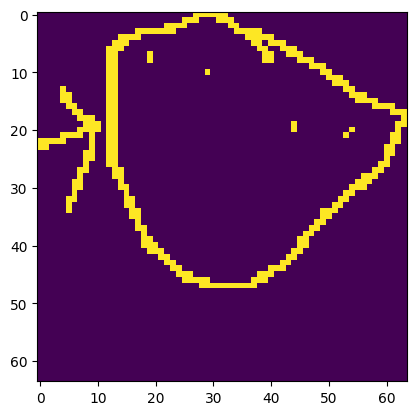

In [10]:
# ejemplo de como se ve una imagen

from matplotlib import pyplot as plt
plt.imshow(hacerImagen(data.image.loc[23212]), interpolation='nearest')
plt.show()

In [11]:
data.loc[:, "image"] = tqdm(data["image"].apply(lambda x: hacerImagen(x)))

100%|██████████| 160000/160000 [00:00<00:00, 2720394.34it/s]


In [12]:
data = data.sample(len(data))
data = data.reset_index()
del data['index']

In [13]:
sparsedImages = [csr_matrix(im) for im in data['image']]
labels = data.preds

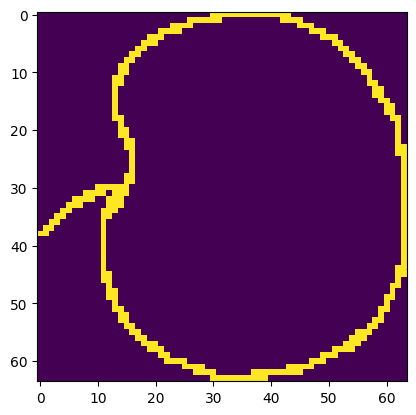

(None, 'apple')

In [25]:
num = 4001

from matplotlib import pyplot as plt
plt.imshow(data.image[num], interpolation='nearest')
plt.show(), labels[num]


Exportacion de los datos

In [27]:
with open('./images64x64', 'wb') as images:
    pickle.dump(sparsedImages, images, protocol=4)
with open('./labels64x64', 'wb') as labelsDir:
    pickle.dump(labels, labelsDir, protocol=4)